In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

Read dataset

In [2]:
df=pd.read_csv("data/togo-dapaong_qc.csv")
#df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [3]:
df.shape

(525600, 19)

In [4]:
df.columns

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')

Summary Statistics & Missing-Value Report

In [4]:
# Summary statistics for numeric columns
summary_stats = df.describe()
print(summary_stats)

# Missing value report
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])


# List columns with >5% nulls
threshold = 0.05 * len(df)
high_nulls = missing_values[missing_values > threshold]
print("Columns with >5% nulls:", high_nulls.index.tolist())

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0.000000      24.2000

In [5]:
print("An overview of the dataset: the shape of the dataset")
print(df.info())

An overview of the dataset: the shape of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600

Outlier Detection & Basic Cleaning

In [5]:
# Assuming df is your DataFrame
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
outlier_flags = {}

# Compute Z-scores and flag outliers
for col in key_columns:
    z_scores = stats.zscore(df[col].dropna())
    outlier_flags[col] = abs(z_scores) > 3
    df[col + '_outlier'] = outlier_flags[col]

# Count and log outliers
total_outliers = sum(outlier_flags[col].sum() for col in key_columns)
print(f"Total outliers flagged: {total_outliers}")

# Drop or impute missing values in key columns
missing_values = df[key_columns].isnull().sum()
print(f"Missing values before imputation:\n{missing_values}")

df[key_columns] = df[key_columns].fillna(df[key_columns].median())

# Verify missing values after imputation
missing_values_after = df[key_columns].isnull().sum()
print(f"Missing values after imputation:\n{missing_values_after}")

# Compute Z-scores and flag outliers for all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
z_scores = np.abs(stats.zscore(df[numeric_cols].dropna()))
outlier_flags_all = (z_scores > 3).any(axis=1)
print(f"Number of outlier samples flagged in all numeric columns: {outlier_flags_all.sum()}")
# Export cleaned DataFrame
df.to_csv('data/togo_clean.csv', index=False)

Total outliers flagged: 12550
Missing values before imputation:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Missing values after imputation:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Number of outlier samples flagged in all numeric columns: 0


Time Series Analysis

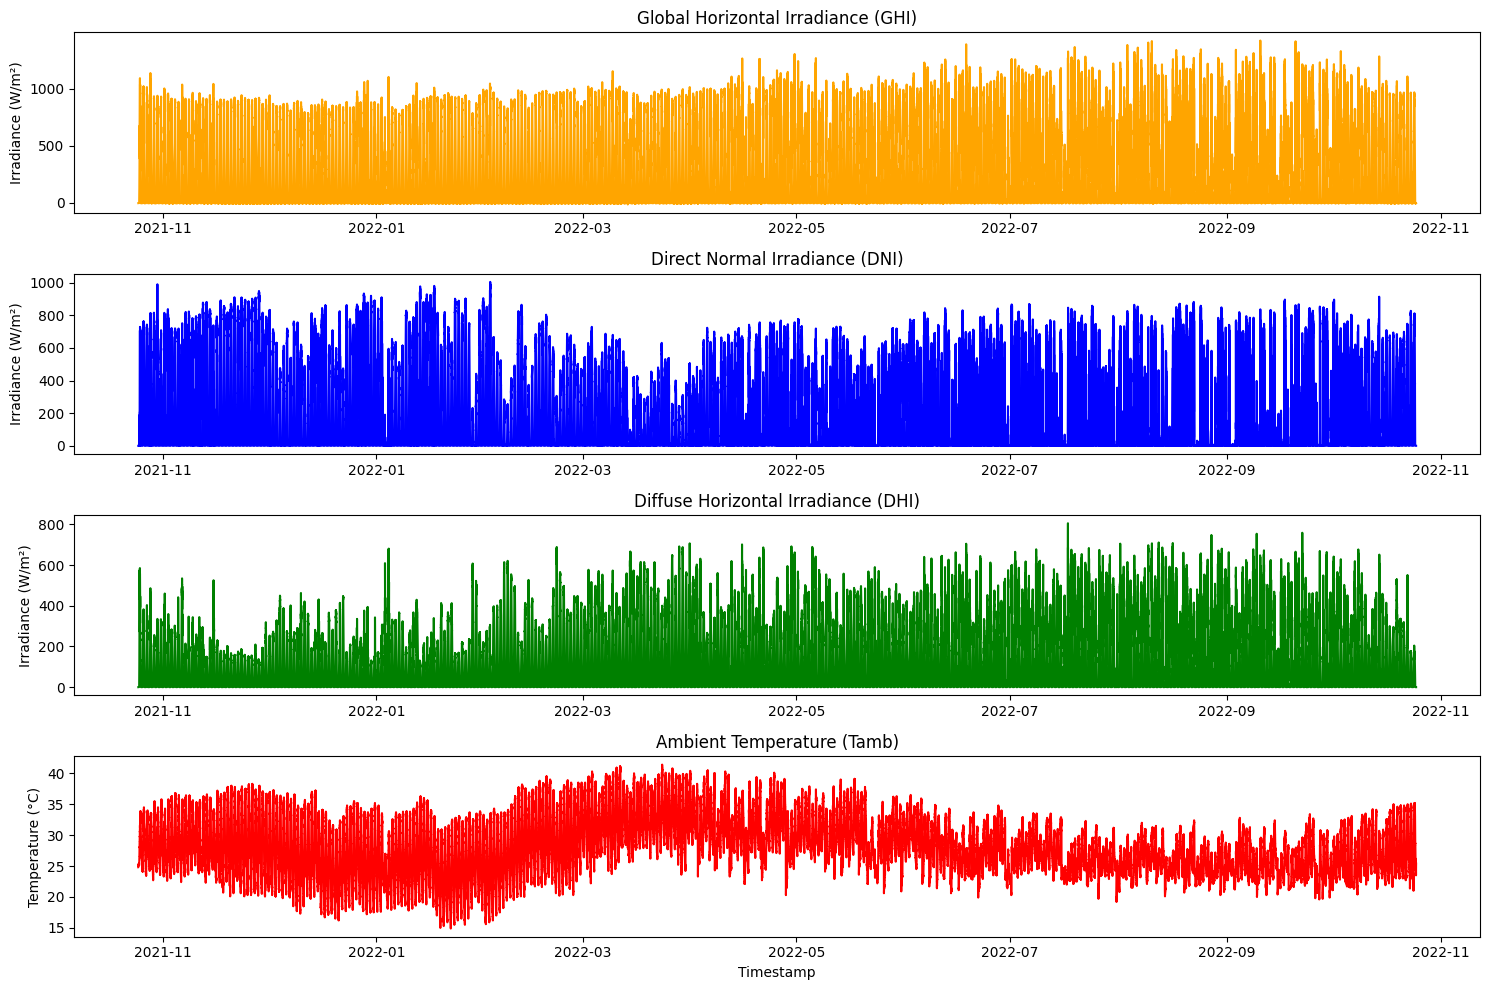

In [6]:
# Ensure timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Plot GHI, DNI, DHI, and Tamb
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(df['Timestamp'], df['GHI'], label='GHI', color='orange')
plt.title('Global Horizontal Irradiance (GHI)')
plt.ylabel('Irradiance (W/m²)')

plt.subplot(4, 1, 2)
plt.plot(df['Timestamp'], df['DNI'], label='DNI', color='blue')
plt.title('Direct Normal Irradiance (DNI)')
plt.ylabel('Irradiance (W/m²)')

plt.subplot(4, 1, 3)
plt.plot(df['Timestamp'], df['DHI'], label='DHI', color='green')
plt.title('Diffuse Horizontal Irradiance (DHI)')
plt.ylabel('Irradiance (W/m²)')

plt.subplot(4, 1, 4)
plt.plot(df['Timestamp'], df['Tamb'], label='Tamb', color='red')
plt.title('Ambient Temperature (Tamb)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Timestamp')

plt.tight_layout()
plt.show()

Cleaning Impact

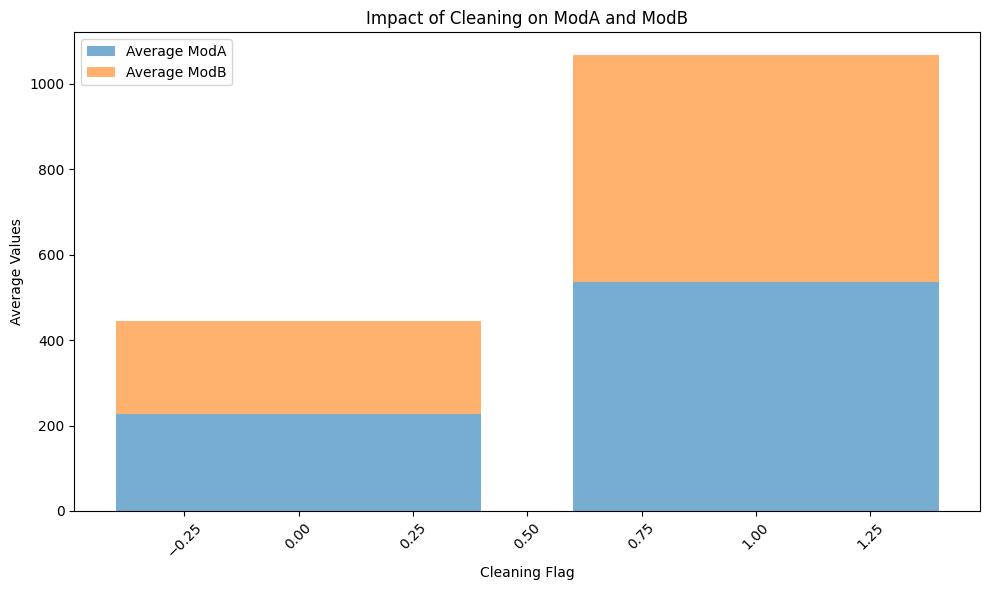

In [7]:
# Group by cleaning flag and calculate mean for ModA and ModB
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(cleaning_impact['Cleaning'], cleaning_impact['ModA'], alpha=0.6, label='Average ModA')
plt.bar(cleaning_impact['Cleaning'], cleaning_impact['ModB'], alpha=0.6, label='Average ModB', bottom=cleaning_impact['ModA'])
plt.title('Impact of Cleaning on ModA and ModB')
plt.xlabel('Cleaning Flag')
plt.ylabel('Average Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


Correlation & Relationship Analysis

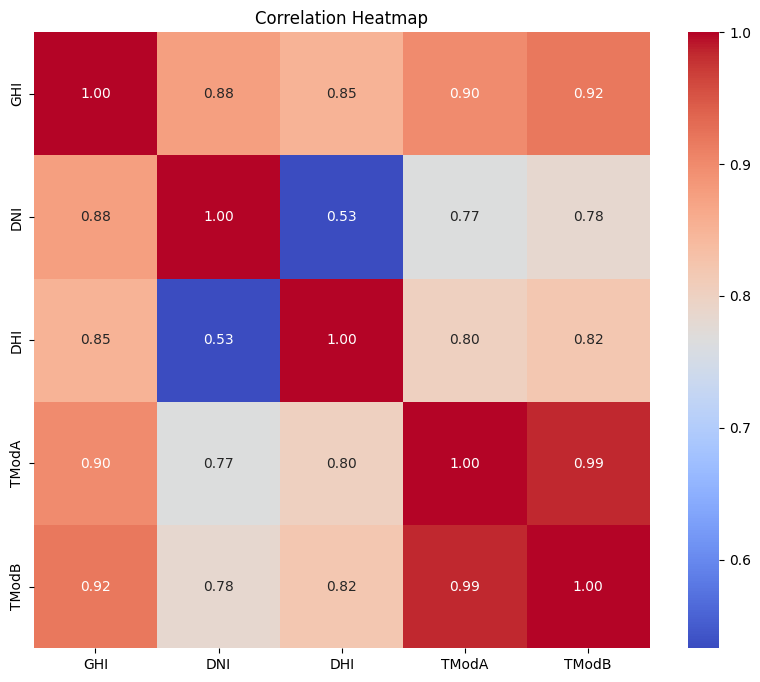

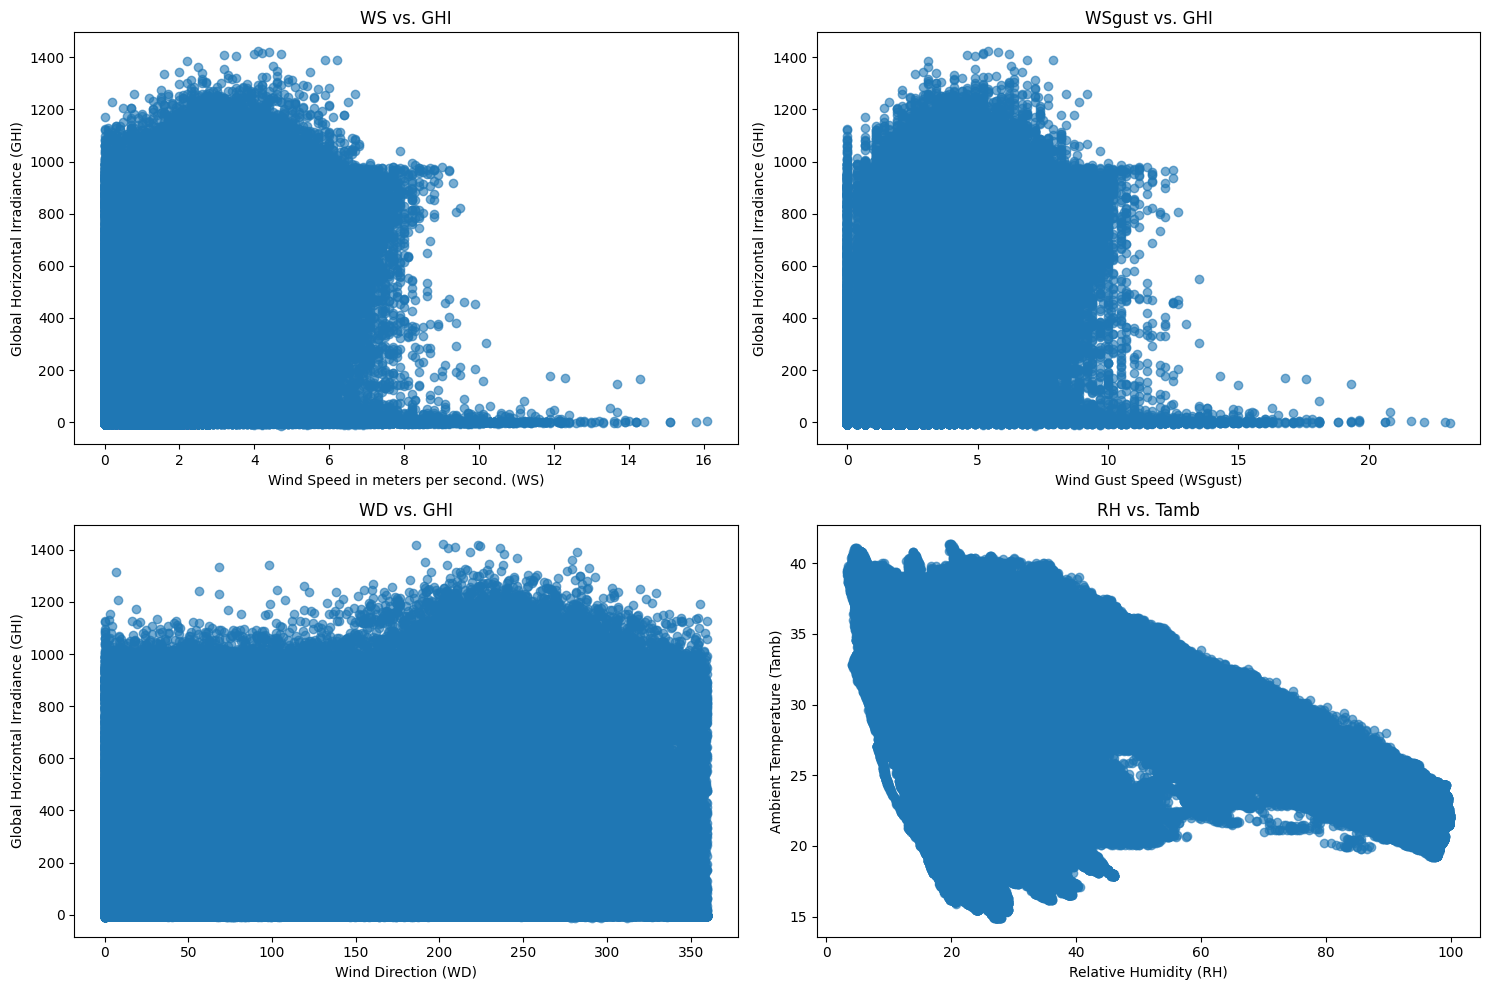

In [8]:
# 1. Heatmap of correlations
correlation_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
correlation_matrix = df[correlation_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

# 2. Scatter plots
plt.figure(figsize=(15, 10))

# Scatter plot: WS vs. GHI
plt.subplot(2, 2, 1)
plt.scatter(df['WS'], df['GHI'], alpha=0.6)
plt.title('WS vs. GHI')
plt.xlabel('Wind Speed in meters per second. (WS)')
plt.ylabel('Global Horizontal Irradiance (GHI)')

# Scatter plot: WSgust vs. GHI
plt.subplot(2, 2, 2)
plt.scatter(df['WSgust'], df['GHI'], alpha=0.6)
plt.title('WSgust vs. GHI')
plt.xlabel('Wind Gust Speed (WSgust)')
plt.ylabel('Global Horizontal Irradiance (GHI)')

# Scatter plot: WD vs. GHI
plt.subplot(2, 2, 3)
plt.scatter(df['WD'], df['GHI'], alpha=0.6)
plt.title('WD vs. GHI')
plt.xlabel('Wind Direction (WD)')
plt.ylabel('Global Horizontal Irradiance (GHI)')

# Scatter plot: RH vs. Tamb
plt.subplot(2, 2, 4)
plt.scatter(df['RH'], df['Tamb'], alpha=0.6)
plt.title('RH vs. Tamb')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Ambient Temperature (Tamb)')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

Wind & Distribution Analysis

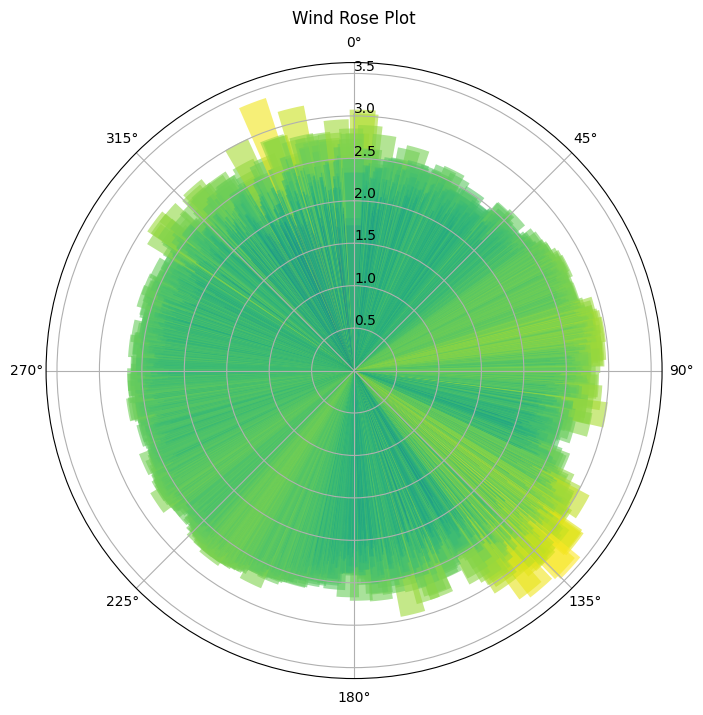

In [9]:
 #Convert wind direction from degrees to radians
df['WD_rad'] = np.radians(df['WD'])

# Calculate the average wind speed for each direction
wind_speed_avg = df.groupby('WD')['WS'].mean()

# Prepare data for the wind rose
angles = np.deg2rad(wind_speed_avg.index)  # Wind direction in radians
radii = wind_speed_avg.values  # Average wind speed

# Create the wind rose plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Create bars for each wind direction
bars = ax.bar(angles, radii, width=0.1, bottom=0.0)

# Customize the bars
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.viridis(r / max(radii)))  # Color based on wind speed
    bar.set_alpha(0.6)

# Set the title and labels
ax.set_title('Wind Rose Plot', va='bottom')
ax.set_theta_zero_location('N')  # Set the zero direction to North
ax.set_theta_direction(-1)  # Clockwise direction
ax.set_rlabel_position(0)  # Position of radial labels

plt.show()

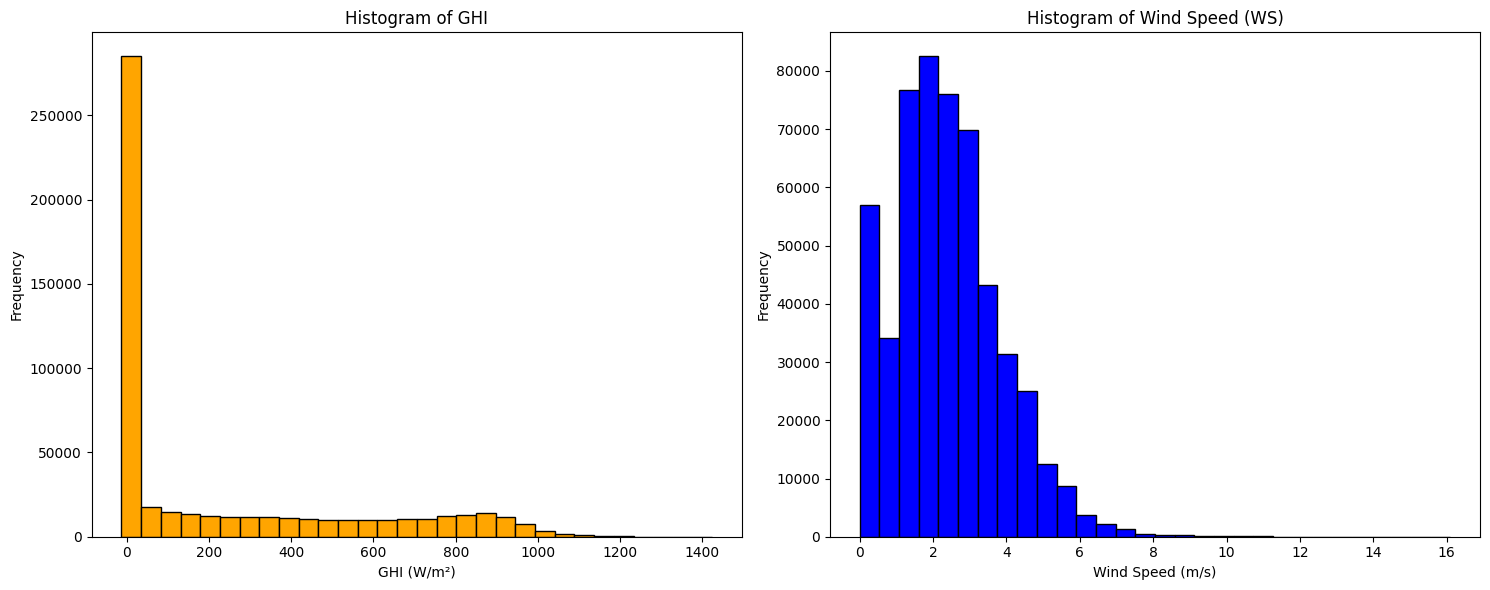

In [10]:
# Histograms for GHI and WS
plt.figure(figsize=(15, 6))

# Histogram for GHI
plt.subplot(1, 2, 1)
plt.hist(df['GHI'], bins=30, color='orange', edgecolor='black')
plt.title('Histogram of GHI')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')

# Histogram for WS
plt.subplot(1, 2, 2)
plt.hist(df['WS'], bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Wind Speed (WS)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Temperature Analysis

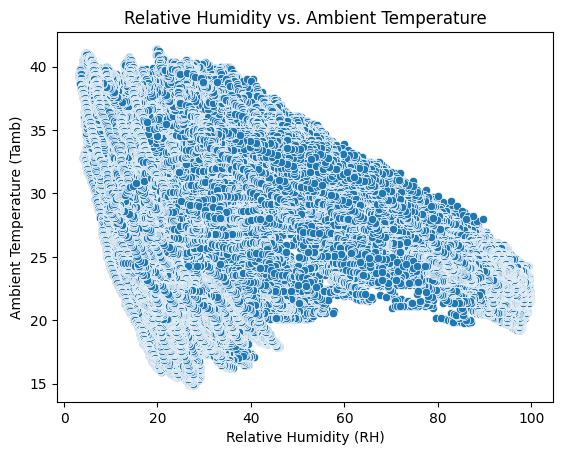

In [11]:
# Examine how RH influences temperature
sns.scatterplot(data=df, x='RH', y='Tamb')
plt.title('Relative Humidity vs. Ambient Temperature')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Ambient Temperature (Tamb)')
plt.show()

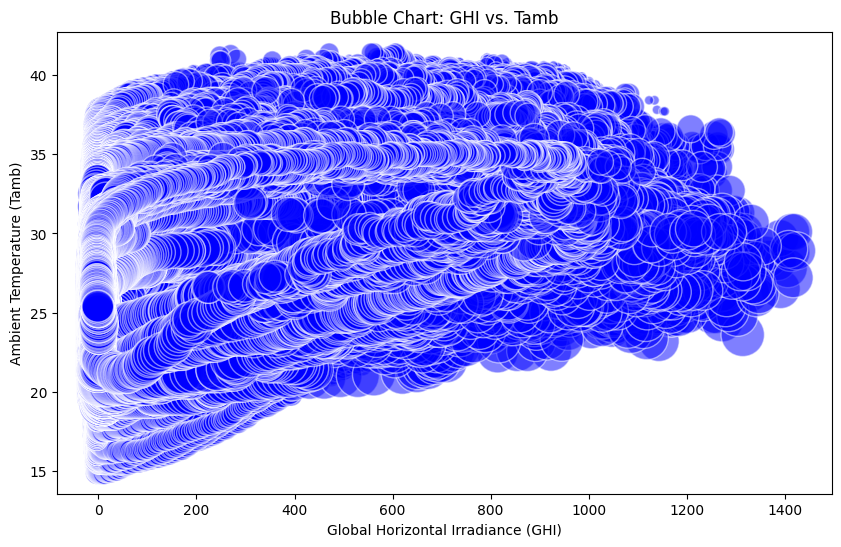

In [12]:
# Bubble chart: GHI vs. Tamb with bubble size = RH
plt.figure(figsize=(10, 6))
plt.scatter(df['GHI'], df['Tamb'], s=df['RH']*10, alpha=0.5, c='blue', edgecolors='w')
plt.title('Bubble Chart: GHI vs. Tamb')
plt.xlabel('Global Horizontal Irradiance (GHI)')
plt.ylabel('Ambient Temperature (Tamb)')
plt.show()

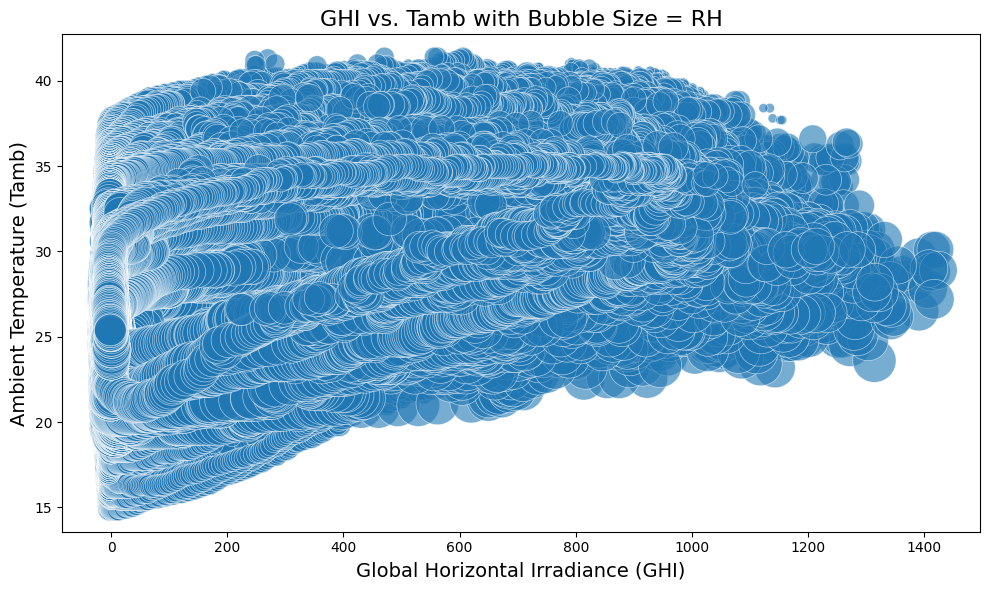

In [16]:
# Choose bubble size variable (RH or BP)
bubble_size_variable = 'RH'  # Change to 'BP' if desired

# Create bubble plot
plt.figure(figsize=(10, 6))
plt.scatter(df['GHI'], df['Tamb'], 
            s=df[bubble_size_variable] * 10,  # Scale bubble size for visibility
            alpha=0.6, edgecolors="w", linewidth=0.5)

# Set titles and labels
plt.title('GHI vs. Tamb with Bubble Size = ' + bubble_size_variable, fontsize=16)
plt.xlabel('Global Horizontal Irradiance (GHI)', fontsize=14)
plt.ylabel('Ambient Temperature (Tamb)', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()